In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourdata/Power_consumption.csv


In [2]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
from matplotlib import pyplot as plt


In [4]:
data= pd.read_csv('../input/hourdata/Power_consumption.csv')

In [5]:
data.head()

,date_time,AC 1,AC 2,AC 3,AC 4,AC 5,AC 6,AC 7,AC 8,AC 9,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,city
0,2019-08-01 00:00:00,6.841507,8.501703,1.801855,0.975186,2.232007,4.302977,2.677340,4.825840,3.652807,...,13,15,56,0.0,998,31,10,86,11,Gurgaon
1,2019-08-01 01:00:00,7.407684,8.459075,1.490131,1.842207,2.236677,4.314749,2.610280,4.463227,3.053721,...,14,19,58,0.0,998,31,10,96,11,Gurgaon
2,2019-08-01 02:00:00,7.350885,8.113246,1.482323,1.465390,1.991346,4.216204,2.753061,3.801375,3.115622,...,14,23,60,0.0,998,31,10,107,11,Gurgaon
3,2019-08-01 03:00:00,6.639281,7.923313,2.238207,1.440677,2.091048,4.734834,3.044784,3.895697,2.844864,...,14,28,62,0.0,998,30,10,118,11,Gurgaon
4,2019-08-01 04:00:00,6.597653,7.300900,1.744991,2.547984,1.872143,3.600600,2.918532,3.768754,3.383187,...,14,28,61,0.0,999,31,10,121,11,Gurgaon


In [6]:
## we will take AC1 first and try to forecast it 
#3 we will consider temp variable also

In [7]:
## Before Forecasting we will do time series analysis first and see seasonality etc 


In [8]:
value= data[['AC 1','tempC']]

In [9]:
value.shape

(1464, 2)

In [10]:
## We might add holidays as well here 

In [11]:
holiday = pd.read_html('https://www.calendarlabs.com/holidays/india/2021')


In [12]:
len(holiday)

2

In [13]:
holiday=holiday[1]

In [14]:
holiday

,DAY,DATE,HOLIDAY
0,FridayFri,"Jan 01, 2021Jan 01",New Year's Day
1,ThursdayThu,"Jan 14, 2021Jan 14",Makar Sankranti / Pongal
2,TuesdayTue,"Jan 26, 2021Jan 26",Republic Day
3,ThursdayThu,"Mar 11, 2021Mar 11",Maha Shivaratri
4,MondayMon,"Mar 29, 2021Mar 29",Holi
5,FridayFri,"Apr 02, 2021Apr 02",Good Friday
6,TuesdayTue,"Apr 13, 2021Apr 13",Ugadi / Gudi Padwa
7,WednesdayWed,"Apr 21, 2021Apr 21",Ram Navami
8,SundaySun,"Apr 25, 2021Apr 25",Mahavir Jayanti
9,SaturdaySat,"May 01, 2021May 01",Labour Day


In [15]:
def remove_char(x):
    return x[:-6]

In [16]:
holiday['DATE'] = holiday['DATE'].apply(remove_char)


In [17]:
holiday.head()

,DAY,DATE,HOLIDAY
0,FridayFri,"Jan 01, 2021",New Year's Day
1,ThursdayThu,"Jan 14, 2021",Makar Sankranti / Pongal
2,TuesdayTue,"Jan 26, 2021",Republic Day
3,ThursdayThu,"Mar 11, 2021",Maha Shivaratri
4,MondayMon,"Mar 29, 2021",Holi


In [18]:
from datetime import datetime


def mdy_to_ymd(d):
    return datetime.strptime(d, '%b %d, %Y').strftime('%Y-%m-%d')

In [19]:
holiday['DATE'] = holiday['DATE'].apply(mdy_to_ymd)


In [20]:
holiday.head()

,DAY,DATE,HOLIDAY
0,FridayFri,2021-01-01,New Year's Day
1,ThursdayThu,2021-01-14,Makar Sankranti / Pongal
2,TuesdayTue,2021-01-26,Republic Day
3,ThursdayThu,2021-03-11,Maha Shivaratri
4,MondayMon,2021-03-29,Holi


In [21]:
holiday['DATE'] = pd.to_datetime(holiday.DATE) - pd.offsets.DateOffset(years=2)


In [22]:
holiday.drop(['DAY'],axis=1,inplace=True)

In [23]:
holiday.head()

,DATE,HOLIDAY
0,2019-01-01,New Year's Day
1,2019-01-14,Makar Sankranti / Pongal
2,2019-01-26,Republic Day
3,2019-03-11,Maha Shivaratri
4,2019-03-29,Holi


In [24]:
holiday['holiday_flag']=1

In [25]:
holiday.drop(['HOLIDAY'],axis=1,inplace=True)

In [26]:
dates=holiday['DATE'].dt.date.tolist()

In [27]:
data['date_time']= pd.to_datetime(data['date_time'])

In [28]:
data = data.set_index('date_time').asfreq('H')


In [29]:
data.head()

,AC 1,AC 2,AC 3,AC 4,AC 5,AC 6,AC 7,AC 8,AC 9,AC 10,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,city
date_time,,,,,,,,,,,,,,,,,,,,,
2019-08-01 00:00:00,6.841507,8.501703,1.801855,0.975186,2.232007,4.302977,2.677340,4.825840,3.652807,2.555998,...,13,15,56,0.0,998,31,10,86,11,Gurgaon
2019-08-01 01:00:00,7.407684,8.459075,1.490131,1.842207,2.236677,4.314749,2.610280,4.463227,3.053721,2.658946,...,14,19,58,0.0,998,31,10,96,11,Gurgaon
2019-08-01 02:00:00,7.350885,8.113246,1.482323,1.465390,1.991346,4.216204,2.753061,3.801375,3.115622,2.803299,...,14,23,60,0.0,998,31,10,107,11,Gurgaon
2019-08-01 03:00:00,6.639281,7.923313,2.238207,1.440677,2.091048,4.734834,3.044784,3.895697,2.844864,2.731836,...,14,28,62,0.0,998,30,10,118,11,Gurgaon
2019-08-01 04:00:00,6.597653,7.300900,1.744991,2.547984,1.872143,3.600600,2.918532,3.768754,3.383187,2.597658,...,14,28,61,0.0,999,31,10,121,11,Gurgaon


In [30]:
#data.loc['2019-08-01':'2019-08-15']
data['date']= pd.to_datetime(data.index).date

In [31]:
data['holiday_flag']=0

In [32]:
pd.to_datetime(dates[0])

Timestamp('2019-01-01 00:00:00')

In [33]:
for value in dates:
    indexes=data[data['date']== pd.to_datetime(value.strftime('%Y-%m-%d')) ].index.values
    if len(indexes) > 1:
        for i in indexes:
            data.at[i, 'holiday_flag']=1
        else:
            continue
            

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


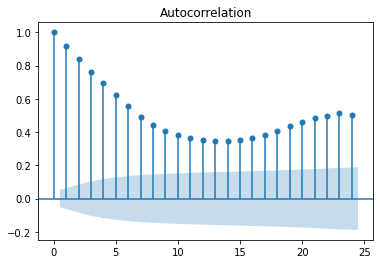

In [34]:
plot_acf(data['AC 1'],lags=24)  # Daily lag
plt.show()

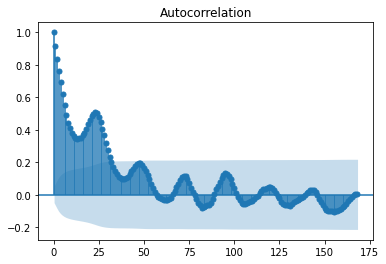

In [35]:
plot_acf(data['AC 1'],lags=168)  # weekly lag
plt.show()

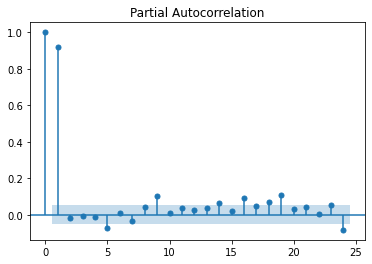

In [36]:
plot_pacf(data['AC 1'],lags=24)
plt.show()

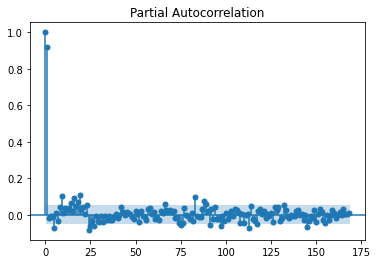

In [37]:
plot_pacf(data['AC 1'],lags=168)
plt.show()

In [38]:
## PACf drop straigth after 1 st lag means there is AR term
## Auto correlation shows hints of seasonality

In [39]:
data.sort_index(inplace= True)

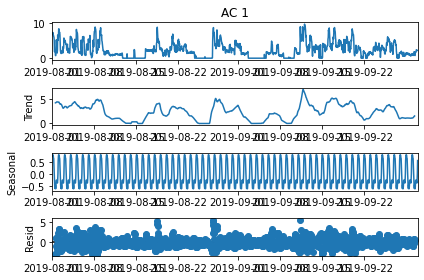

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(data['AC 1'], model="additive")
decompose_data.plot();

<AxesSubplot:xlabel='date_time'>

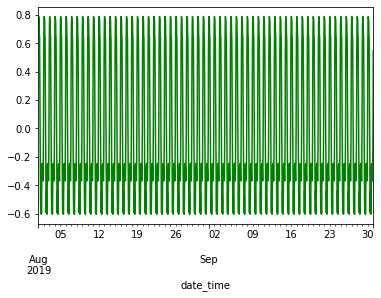

In [41]:
seasonality=decompose_data.seasonal
seasonality.plot(color='green')

In [42]:
#df = pd.DataFrame(
#        {'date_time': pd.date_range('2019-08-01', '2019-10-01', freq='1H', closed='left')}
 #    )

In [43]:
daily=data[['AC 1']].resample('D').mean()

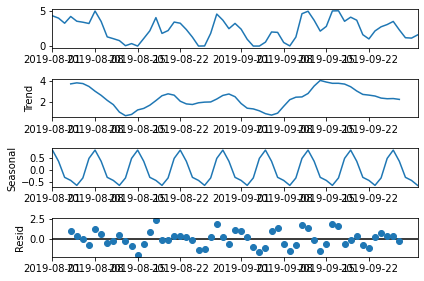

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(daily, model="additive")
decompose_data.plot();

<AxesSubplot:xlabel='date_time'>

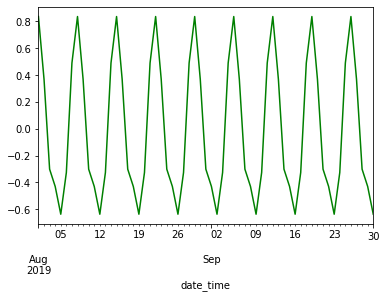

In [45]:
seasonality=decompose_data.seasonal
seasonality.plot(color='green')

In [46]:
# We can easily see the seasonality pattern when data is sampled to daily

In [47]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(data['AC 1'], autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)


1. ADF :  -3.642017123677277
2. P-Value :  0.005006732011038638
3. Num Of Lags :  24
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1439
5. Critical Values :
	 1% :  -3.4349024693573584
	 5% :  -2.8635506057382325
	 10% :  -2.5678404322793846


In [48]:
# p value is already lower than 0.05 it is already stationary

In [49]:
data.columns

Index(['AC 1', 'AC 2', 'AC 3', 'AC 4', 'AC 5', 'AC 6', 'AC 7', 'AC 8', 'AC 9',
       'AC 10', 'AC 11', 'AC 12', 'AC 13', 'AC 14', 'AC 15', 'AC 16', 'AC 17',
       'AC 18', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour', 'uvIndex',
       'moon_illumination', 'moonrise', 'moonset', 'sunrise', 'sunset',
       'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph',
       'cloudcover', 'humidity', 'precipMM', 'pressure', 'tempC', 'visibility',
       'winddirDegree', 'windspeedKmph', 'city', 'date', 'holiday_flag'],
      dtype='object')

In [50]:
model_data = data[['AC 1','holiday_flag']]
train = model_data.loc['2019-08-01':'2019-09-15']
test = model_data.loc['2019-09-16':'2019-09-30']

<AxesSubplot:xlabel='date_time'>

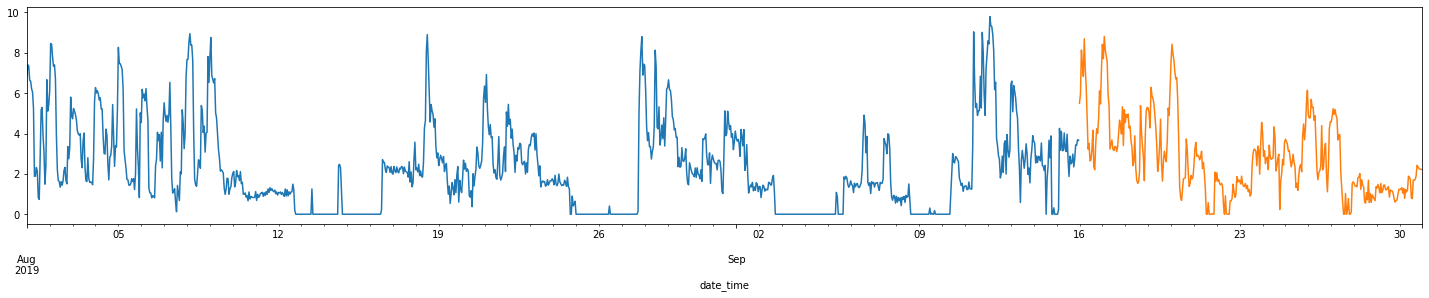

In [51]:
train['AC 1'].plot(figsize=(25,4))
test['AC 1'].plot(figsize=(25,4))

In [52]:
endog = train['AC 1']
exog = sm.add_constant(train[['holiday_flag']])

mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(1,1,1),seasonal_order=(1,1, 0, 168))
model_fit = mod.fit()
model_fit.summary()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20307D+00    |proj g|=  1.46364D-01


 This problem is unconstrained.



At iterate    5    f=  1.19347D+00    |proj g|=  1.31422D-03

At iterate   10    f=  1.19334D+00    |proj g|=  1.20739D-03

At iterate   15    f=  1.19312D+00    |proj g|=  1.09609D-02

At iterate   20    f=  1.19010D+00    |proj g|=  2.22523D-02

At iterate   25    f=  1.17981D+00    |proj g|=  5.57984D-03

At iterate   30    f=  1.17957D+00    |proj g|=  3.16867D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     36      1     0     0   2.290D-06   1.180D+00
  F =   1.1795660814123834     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 AC 1   No. Observations:                 1104
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 168)   Log Likelihood               -1302.241
Date:                              Tue, 07 Dec 2021   AIC                           2616.482
Time:                                      04:30:11   BIC                           2645.525
Sample:                                  08-01-2019   HQIC                          2627.556
                                       - 09-15-2019                                         
Covariance Type:                                opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.057e-06   6485.503   3.17e-10      1.000   -1.27e+04    1.27e+04
holiday_flag    -0.0895      0.327     -0.273      0.785      -0.731       0.552
ar.L1            0.8677      0.026     33.360      0.000       0.817       0.919
ma.L1           -0.9670      0.014    -67.155      0.000      -0.995      -0.939
ar.S.L168       -0.4821      0.021    -22.618      0.000      -0.524      -0.440
sigma2           0.9045      0.024     37.418      0.000       0.857       0.952
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):               865.81
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.38
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

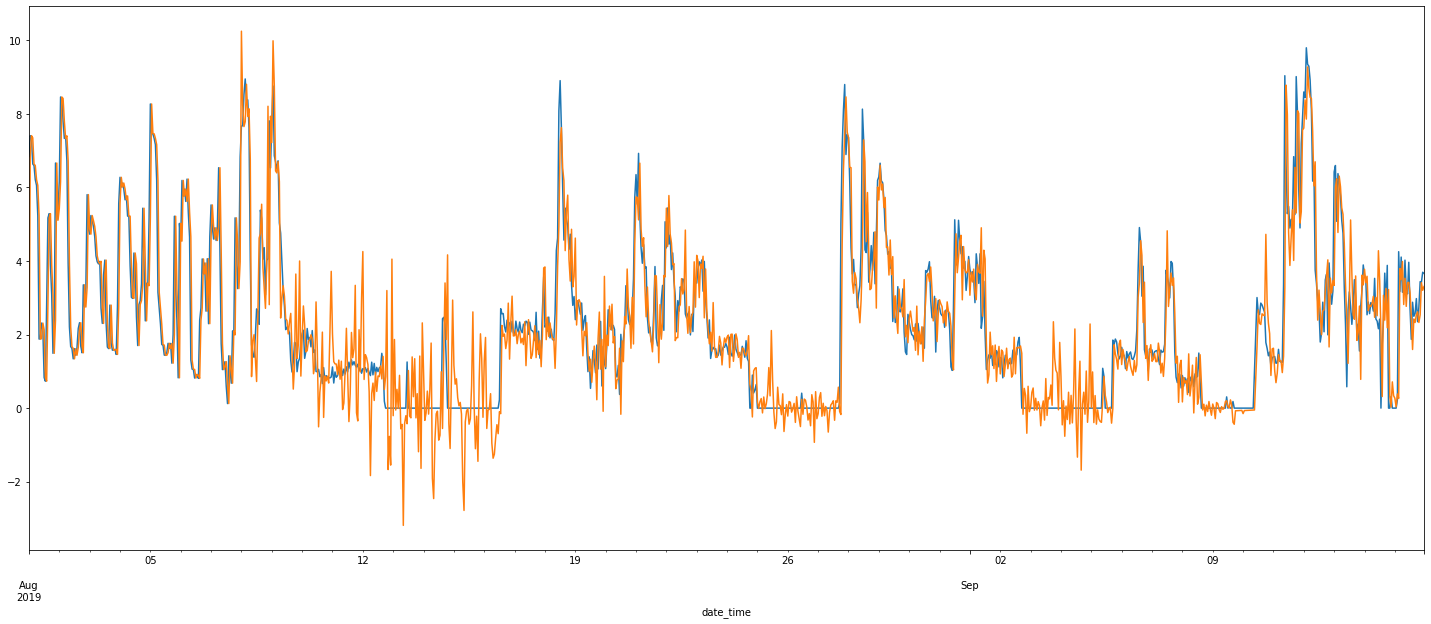

In [53]:
train['AC 1'].plot(figsize=(25,10))
model_fit.fittedvalues.plot()
plt.show()

In [54]:
predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1,exog = sm.add_constant(test[['holiday_flag']]))
test['predicted'] = predict.values
test.tail(5)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,AC 1,holiday_flag,predicted
date_time,,,
2019-09-30 19:00:00,2.336036,0,3.463720
2019-09-30 20:00:00,2.263858,0,3.454260
2019-09-30 21:00:00,2.234928,0,3.446051
2019-09-30 22:00:00,2.218673,0,3.438928
2019-09-30 23:00:00,2.226175,0,3.432748


<AxesSubplot:xlabel='date_time'>

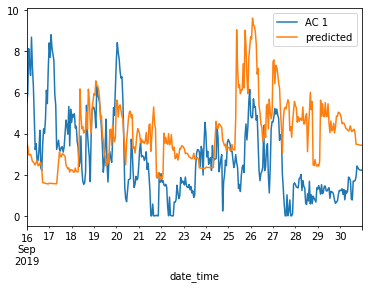

In [55]:
test[['AC 1','predicted']].plot()

In [56]:
del model_fit

In [57]:
## We have made simple model  here without the usage of temperature 
## holiday as an exogenous variable doesnt add anything as mostly it is all 0 only

In [58]:
## we will try to forecast same with fb prophet as well simple forecasting 

In [59]:
data.to_csv('hourly_data.csv',header=True,index=True)